In [1]:
import torch
import matplotlib.pyplot as plt

In [15]:
# Parameters
head_dim = 8          # must be even
theta_base = 10_000
context_length = 32
batch_size, num_heads, seq_len = 2, 2, 16
dtype = torch.float32


In [16]:
# freq_exponents: [0, 2/head_dim, 4/head_dim, ...]
freq_exponents = torch.arange(0, head_dim // 2, dtype=dtype) / head_dim
print("freq_exponents:", freq_exponents)

# inverse frequencies
inv_freq = 1.0 / (theta_base ** freq_exponents)
print("inv_freq shape:", inv_freq.shape)
print(inv_freq)

freq_exponents: tensor([0.0000, 0.1250, 0.2500, 0.3750])
inv_freq shape: torch.Size([4])
tensor([1.0000, 0.3162, 0.1000, 0.0316])


In [17]:
# positions: [0, 1, 2, ..., context_length-1]
positions = torch.arange(context_length, dtype=dtype)

# outer product → shape (context_length, head_dim//2)
angles_half = positions[:, None] * inv_freq[None, :]
print("angles_half shape:", angles_half.shape)

# interleave to shape (context_length, head_dim)
angles = torch.zeros(context_length, head_dim, dtype=dtype)
angles[:, 0::2] = angles_half
angles[:, 1::2] = angles_half

print("angles shape:", angles.shape)
print("angles[0]:", angles[0])   # should be all zeros
print("angles[1]:", angles[1])   # first step


angles_half shape: torch.Size([32, 4])
angles shape: torch.Size([32, 8])
angles[0]: tensor([0., 0., 0., 0., 0., 0., 0., 0.])
angles[1]: tensor([1.0000, 1.0000, 0.3162, 0.3162, 0.1000, 0.1000, 0.0316, 0.0316])


cos shape: torch.Size([32, 8])
sin shape: torch.Size([32, 8])


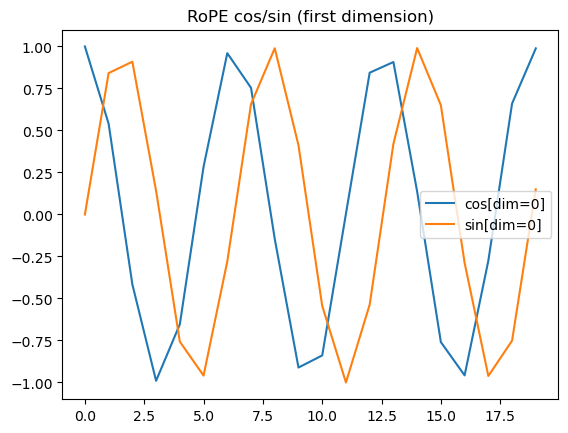

In [18]:
cos = torch.cos(angles)
sin = torch.sin(angles)

print("cos shape:", cos.shape)
print("sin shape:", sin.shape)

# visualize cos/sin for first dim
plt.plot(cos[:20, 0], label="cos[dim=0]")
plt.plot(sin[:20, 0], label="sin[dim=0]")
plt.legend()
plt.title("RoPE cos/sin (first dimension)")
plt.show()


In [19]:
x = torch.randn(batch_size, num_heads, seq_len, head_dim)
print("x shape:", x.shape)
print("First token before RoPE:", x[0, 0, 0])


x shape: torch.Size([2, 2, 16, 8])
First token before RoPE: tensor([ 2.6243, -0.3426, -0.6709,  1.5341,  0.5054,  0.9325,  2.1131,  0.7445])


In [20]:
# Slice cos/sin for seq_len and add batch/head broadcast
cos_b = cos[:seq_len].unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim)
sin_b = sin[:seq_len].unsqueeze(0).unsqueeze(0)

# Split into even/odd parts
x_even = x[..., 0::2]   # (batch, heads, seq, head_dim/2)
x_odd  = x[..., 1::2]

# Apply rotation
x_rot_even = x_even * cos_b[..., 0::2] - x_odd * sin_b[..., 0::2]
x_rot_odd  = x_even * sin_b[..., 1::2] + x_odd * cos_b[..., 1::2]

# Re-interleave results
x_rope = torch.stack([x_rot_even, x_rot_odd], dim=-1).reshape(batch_size, num_heads, seq_len, head_dim)

print("x_rope shape:", x_rope.shape)
print("First token after RoPE:", x_rope[0, 0, 0])


x_rope shape: torch.Size([2, 2, 16, 8])
First token after RoPE: tensor([ 2.6243, -0.3426, -0.6709,  1.5341,  0.5054,  0.9325,  2.1131,  0.7445])


In [21]:
for pos in [0, 1, 5, 10]:
    print(f"\n--- Position {pos} ---")
    print("Before:", x[0, 0, pos])
    print("After :", x_rope[0, 0, pos])



--- Position 0 ---
Before: tensor([ 2.6243, -0.3426, -0.6709,  1.5341,  0.5054,  0.9325,  2.1131,  0.7445])
After : tensor([ 2.6243, -0.3426, -0.6709,  1.5341,  0.5054,  0.9325,  2.1131,  0.7445])

--- Position 1 ---
Before: tensor([-1.3186, -0.5912, -0.6588, -1.7477,  0.7984,  2.5632, -1.0318, -0.4849])
After : tensor([-0.2149, -1.4290, -0.0826, -1.8659,  0.5385,  2.6301, -1.0159, -0.5173])

--- Position 5 ---
Before: tensor([ 1.3652,  0.1738,  0.4317,  0.8661, -0.0891, -0.3465,  0.4032, -0.1050])
After : tensor([ 0.5539, -1.2598, -0.8705,  0.4227,  0.0879, -0.3468,  0.4147, -0.0402])

--- Position 10 ---
Before: tensor([-0.9966, -0.3226,  0.1527, -0.8027, -0.6050, -0.0043, -0.8248, -0.1384])
After : tensor([ 0.6607,  0.8128, -0.1693,  0.7994, -0.3232, -0.5114, -0.7409, -0.3880])
